In [3]:
import numpy as np
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import re

In [4]:
twitter_data = pd.read_csv(r"data/scored_tweets_total.csv")

In [5]:
twitter_data

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point
0,AXTG,2021-03-25 17:50:13+00:00,UCitnow,1375142994920271872a,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EV...,0,0,1.0,NaN
1,AXTG,2021-03-25 17:50:48+00:00,UCitnow,1375143141058080768a,RT @UCitnow: #RT @ldev117: RT @UCitnow: @Short...,0,0,1.0,NaN
2,AXTG,2021-03-25 18:47:48+00:00,Rad7RR,1375157484063584261a,$AXTG Big OTC % Gainer!🚀🚀🚀,1,0,1.0,NaN
3,AXTG,2021-03-25 20:02:03+00:00,GetScanz,1375176172099747845a,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...,1,0,1.0,NaN
4,AXTG,2021-03-25 20:02:48+00:00,christinebarnum,1375176361560604679a,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1,0,1.0,NaN
...,...,...,...,...,...,...,...,...,...
10071,EEENF,2021-04-09 01:00:55+00:00,TVTVentures,1380324815689539585a,Holding until at least summer $WDHR $EEENF $PH...,1,0,0.0,NaN
10072,EEENF,2021-04-09 01:06:47+00:00,BuyLowSell420,1380326289735708672a,@TheFlyingScotto Yep well now that the bushy a...,-1,0,0.0,NaN
10073,EEENF,2021-04-09 01:06:56+00:00,superlars34,1380326328524623873a,$VPER 🚀 $PHIL $IMTL $ABML $UATG $SFOR $LTNC $I...,1,0,0.0,NaN
10074,EEENF,2021-04-09 01:07:55+00:00,DaveWhitman12,1380326575414120448a,RT @jasontrade99: $EEENF 💰💰💰💰🤮🤮🤮🔥🔥🔥🔥🚀🚀🚀🚀🚀🚀,1,0,0.0,NaN


## Extract Pumper Retweet

In [6]:
def extract_twitter_handles_from_dataframe(df):
  """
  Extracts Twitter handles from a pandas DataFrame, where usernames are in
  the 'user.screen_name' column and tweet text is in the 'text' column.

  Args:
    df: The pandas DataFrame.

  Returns:
    A pandas DataFrame with a new column 'mentioned_handles' containing lists of
    extracted Twitter handles.
  """

  def extract_handles(text):
    if isinstance(text, str): #handle nan cases
      pattern = r"@([a-zA-Z0-9_]+)"
      handles = re.findall(pattern, text)
      if len(handles) == 0:
        return None
      return handles
    else:
      return None

  df['mentioned_handles'] = df['text'].apply(extract_handles)
  return df

twitter_df_with_handles = extract_twitter_handles_from_dataframe(twitter_data)

In [7]:
twitter_df_with_handles.columns

Index(['Stock', 'Datetime', 'user.screen_name', 'id_str', 'text', 'Sentiment',
       'Known_Pumper', 'Price_Region', 'Inflection_Point',
       'mentioned_handles'],
      dtype='object')

In [8]:
rt_edge_list = {
  "Source": [],
  "Target": []
}
known_pumpers = {}
for indx in range(twitter_df_with_handles.shape[0]):
  _row = twitter_df_with_handles.loc[indx]
  source = _row["user.screen_name"]
  targets = _row["mentioned_handles"]
  known_pumper = _row["Known_Pumper"]
  if not targets:
    continue
  if known_pumper:
    known_pumpers[source] = True
  for target in targets:
    if source == target:
      continue
    rt_edge_list["Source"].append(source)
    rt_edge_list["Target"].append(target)
    if target not in known_pumpers:
      known_pumpers[target] = False

In [9]:
print(rt_edge_list["Source"][:5])
print(rt_edge_list["Target"][:5])

['UCitnow', 'UCitnow', 'UCitnow', 'UCitnow', 'UCitnow']
['ldev117', 'ShortSqueezed1', 'EVO9MRPLEASE', 'ldev117', 'ShortSqueezed1']


In [10]:
import networkx as nx
import pandas as pd

# Example "Known_Pumper" data (replace with your actual data)
pumper_data = pd.Series(known_pumpers)

# Create a directed graph
G = nx.from_pandas_edgelist(rt_edge_list, source='Source', target='Target')

# Add the 'is_pumper' attribute to each node
for node in G.nodes():
    if node in pumper_data:
        G.nodes[node]['is_pumper'] = pumper_data[node]
    else:
        G.nodes[node]['is_pumper'] = False #Or any default value that you want.

#Example of how to check if a node is a pumper.
print(G.nodes['UCitnow']['is_pumper'])

False


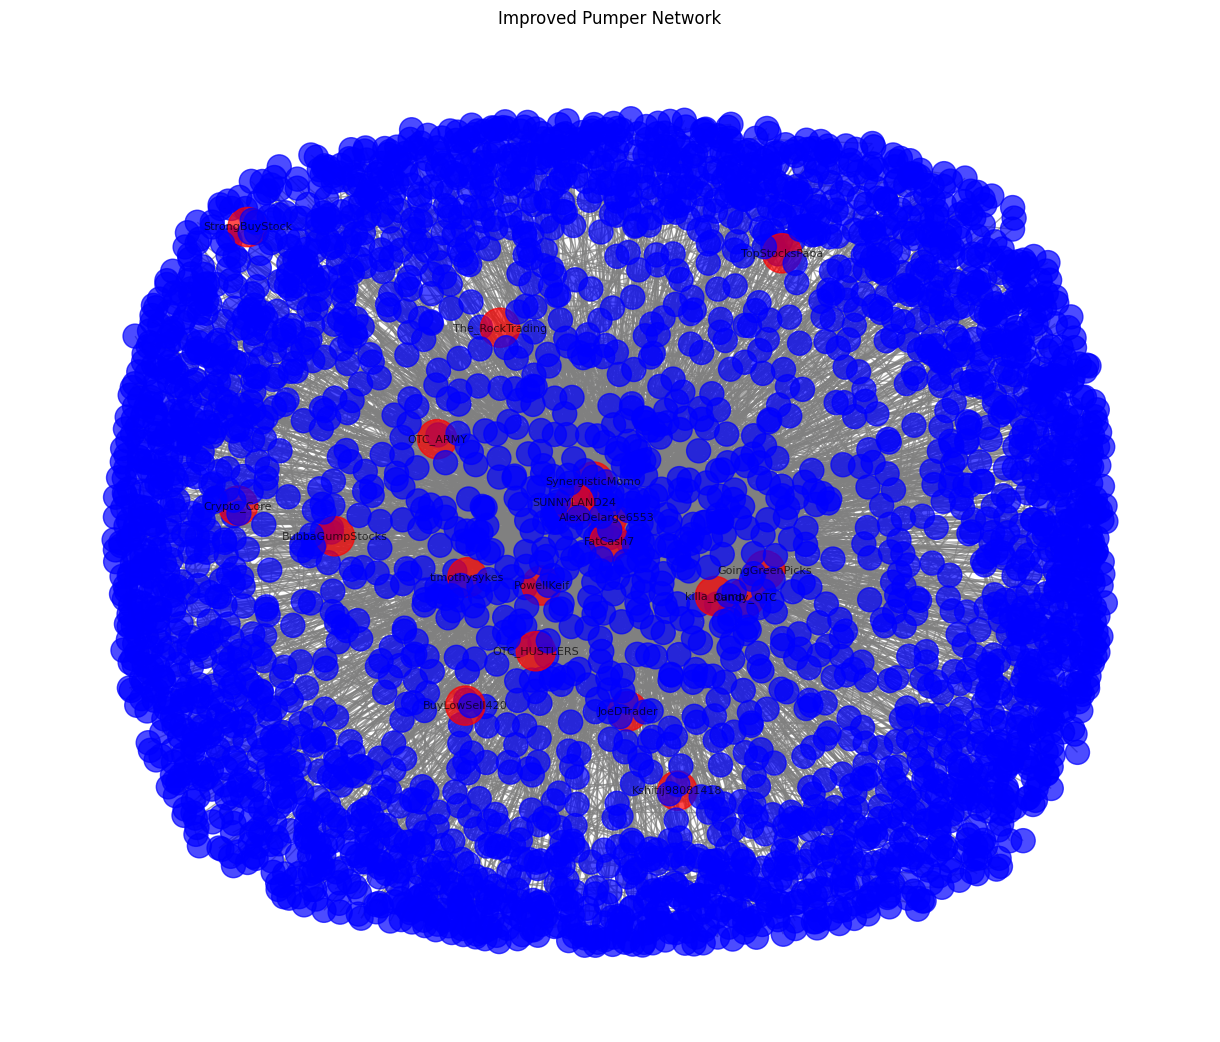

In [11]:
def plot_pumper_graph_from_existing(graph, pumper_data):
    """
    Plots an improved pumper network graph with force-directed layout,
    node coloring, and label filtering.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.
    """

    # 1. Force-Directed Layout
    pos = nx.spring_layout(graph, k=0.15, iterations=20)  # Adjust k and iterations as needed

    # 2. Node Coloring and Sizing
    node_colors = []
    node_sizes = []
    for node in graph.nodes():
        if node in pumper_data and pumper_data[node]:
            node_colors.append('red')  # Pumper nodes are red
            node_sizes.append(800) #Make pumpers larger.
        else:
            node_colors.append('blue') # Non-pumper nodes are blue
            node_sizes.append(300)

    # 3. Label Filtering
    labels = {}
    for node in graph.nodes():
        if node in pumper_data and pumper_data[node]:
            labels[node] = node  # Show labels only for pumpers

    # 4. Visualization
    plt.figure(figsize=(12, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels,
            node_color=node_colors, node_size=node_sizes,
            font_size=8, edge_color='gray', alpha=0.7)
    plt.title("Improved Pumper Network")
    plt.show()
    
plot_pumper_graph_from_existing(G, pumper_data)

In [12]:
def calculate_average_centrality(graph, pumper_data):
    """
    Calculates the average centrality scores for pumpers and non-pumpers.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.

    Returns:
        A dictionary containing the average centrality scores.
    """

    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    non_pumper_nodes = [node for node, is_pumper in pumper_data.items() if not is_pumper]

    # Calculate Centrality Measures
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    # Average Centrality for Pumpers
    avg_pumper_degree = np.mean([degree_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_betweenness = np.mean([betweenness_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0

    # Average Centrality for Non-Pumpers
    avg_non_pumper_degree = np.mean([degree_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_betweenness = np.mean([betweenness_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0

    return {
        'avg_pumper_degree': avg_pumper_degree,
        'avg_pumper_betweenness': avg_pumper_betweenness,
        'avg_pumper_eigenvector': avg_pumper_eigenvector,
        'avg_non_pumper_degree': avg_non_pumper_degree,
        'avg_non_pumper_betweenness': avg_non_pumper_betweenness,
        'avg_non_pumper_eigenvector': avg_non_pumper_eigenvector,
    }


average_centralities = calculate_average_centrality(G, pumper_data)

# Print the average centrality scores
for metric, value in average_centralities.items():
    print(f"{metric}: {value}")

avg_pumper_degree: 0.0074353063411149705
avg_pumper_betweenness: 0.007845397776172148
avg_pumper_eigenvector: 0.02565403810786402
avg_non_pumper_degree: 0.0018547718299854394
avg_non_pumper_betweenness: 0.001174307754541526
avg_non_pumper_eigenvector: 0.01015554991691486


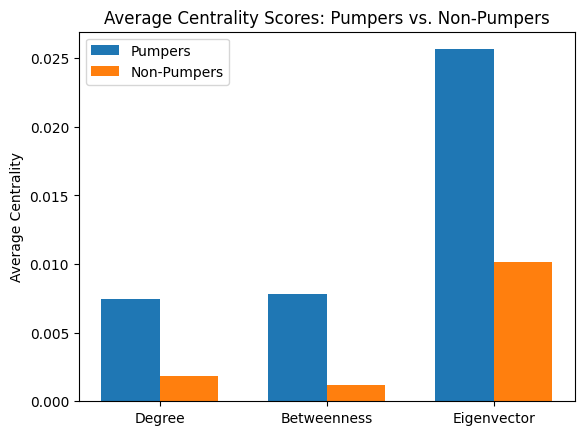


Statistical Significance (T-Tests):
Degree: t = 4.527, p = 6.650e-06
Betweenness: t = 5.034, p = 5.622e-07
Eigenvector: t = 2.582, p = 9.956e-03


In [13]:
from scipy import stats

def visualize_and_test_centrality(graph, pumper_data):
    """
    Visualizes and performs statistical tests on average centrality scores.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.
    """

    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    non_pumper_nodes = [node for node, is_pumper in pumper_data.items() if not is_pumper]

    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    avg_pumper_degree = np.mean([degree_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_betweenness = np.mean([betweenness_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0

    avg_non_pumper_degree = np.mean([degree_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_betweenness = np.mean([betweenness_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0

    # 1. Visualization (Bar Charts)
    centrality_types = ['Degree', 'Betweenness', 'Eigenvector']
    pumper_avgs = [avg_pumper_degree, avg_pumper_betweenness, avg_pumper_eigenvector]
    non_pumper_avgs = [avg_non_pumper_degree, avg_non_pumper_betweenness, avg_non_pumper_eigenvector]

    x = np.arange(len(centrality_types))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pumper_avgs, width, label='Pumpers')
    rects2 = ax.bar(x + width/2, non_pumper_avgs, width, label='Non-Pumpers')

    ax.set_ylabel('Average Centrality')
    ax.set_title('Average Centrality Scores: Pumpers vs. Non-Pumpers')
    ax.set_xticks(x)
    ax.set_xticklabels(centrality_types)
    ax.legend()

    plt.show()

    # 2. Statistical Significance (T-Tests)

    pumper_degree_values = [degree_centrality[node] for node in pumper_nodes]
    non_pumper_degree_values = [degree_centrality[node] for node in non_pumper_nodes]

    pumper_betweenness_values = [betweenness_centrality[node] for node in pumper_nodes]
    non_pumper_betweenness_values = [betweenness_centrality[node] for node in non_pumper_nodes]

    pumper_eigenvector_values = [eigenvector_centrality[node] for node in pumper_nodes]
    non_pumper_eigenvector_values = [eigenvector_centrality[node] for node in non_pumper_nodes]

    t_degree, p_degree = stats.ttest_ind(pumper_degree_values, non_pumper_degree_values)
    t_betweenness, p_betweenness = stats.ttest_ind(pumper_betweenness_values, non_pumper_betweenness_values)
    t_eigenvector, p_eigenvector = stats.ttest_ind(pumper_eigenvector_values, non_pumper_eigenvector_values)

    print("\nStatistical Significance (T-Tests):")
    print(f"Degree: t = {t_degree:.3f}, p = {p_degree:.3e}")
    print(f"Betweenness: t = {t_betweenness:.3f}, p = {p_betweenness:.3e}")
    print(f"Eigenvector: t = {t_eigenvector:.3f}, p = {p_eigenvector:.3e}")

visualize_and_test_centrality(G, pumper_data)

In [16]:
import networkx as nx
import pandas as pd
import pickle

def analyze_pumper_network(graph, pumper_data):
    """
    Analyzes the pumper network graph and calculates relevant metrics.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.

    Returns:
        A dictionary containing the calculated metrics.
    """

    metrics = {}

    # 1. Centrality Measures
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    metrics['degree_centrality'] = degree_centrality
    metrics['betweenness_centrality'] = betweenness_centrality
    metrics['eigenvector_centrality'] = eigenvector_centrality

    # 2. Community Detection (Louvain Algorithm)
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(graph)
        metrics['communities'] = partition
    except ImportError:
        print("Community library not found. Install it with: pip install python-louvain")
        metrics['communities'] = None

    # 3. Graph Density and Transitivity
    metrics['density'] = nx.density(graph)
    try:
        metrics['transitivity'] = nx.transitivity(graph)
    except:
        metrics['transitivity'] = None

    # 4. Path Analysis (Example: Shortest Paths between Pumpers)
    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    shortest_paths = {}
    for pumper1 in pumper_nodes:
        for pumper2 in pumper_nodes:
            if pumper1 != pumper2:
                try:
                    shortest_paths[(pumper1, pumper2)] = nx.shortest_path(graph, pumper1, pumper2)
                except nx.NetworkXNoPath:
                    shortest_paths[(pumper1, pumper2)] = None
    metrics['shortest_paths'] = shortest_paths

    return metrics

results = analyze_pumper_network(G, pumper_data)

# Save the results to a JSON file
filename = "pumper_network_analysis_results.pkl"

with open(filename, 'wb') as f:
    pickle.dump(results, f)  # indent=4 for pretty printing

print(f"Results saved to {filename}")

Results saved to pumper_network_analysis_results.pkl


In [17]:
results

{'degree_centrality': {'UCitnow': 0.0009253547193090684,
  'ldev117': 0.00030845157310302283,
  'ShortSqueezed1': 0.00030845157310302283,
  'EVO9MRPLEASE': 0.00030845157310302283,
  'christinebarnum': 0.0024676125848241827,
  'GetScanz': 0.00215916101172116,
  'CharlesMorriz': 0.0012338062924120913,
  'HiegerBrian': 0.00030845157310302283,
  'jehause': 0.00215916101172116,
  'soupbone1965': 0.0012338062924120913,
  'LeifBierer': 0.0012338062924120913,
  'DaveWhitman12': 0.05983960518198643,
  'HassanSof': 0.00030845157310302283,
  'HilBilyHangdown': 0.003701418877236274,
  'vasquez_randi': 0.005860579888957434,
  'AngryRed316': 0.005552128315854411,
  'PowellKeif': 0.0033929673041332513,
  'JacerJulian': 0.008945095619987662,
  'JoeDTrader': 0.0046267735965453425,
  'ZZach1958': 0.004009870450339297,
  'Aronphl': 0.0012338062924120913,
  'Clay2411': 0.0006169031462060457,
  'Mapleki31497944': 0.0030845157310302285,
  'Kshitij98081418': 0.00215916101172116,
  'LV_train': 0.0006169031462

In [18]:
twitter_df_with_handles.columns

Index(['Stock', 'Datetime', 'user.screen_name', 'id_str', 'text', 'Sentiment',
       'Known_Pumper', 'Price_Region', 'Inflection_Point',
       'mentioned_handles'],
      dtype='object')

## Create temporal feature

In [25]:
import pandas as pd

def create_temporal_features(df):
    """
    Creates temporal features from the 'Datetime' column.
    """

    df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None) #remove tz
    if 'Inflection_Point' in df.columns:
        df['Inflection_Point'] = pd.to_datetime(df['Inflection_Point']).dt.tz_localize(None) #remove tz

        df['time_since_inflection'] = (df['Datetime'] - df['Inflection_Point']).dt.total_seconds()

    if 'user.screen_name' in df.columns:
        df['1hr_tweet_count'] = df.groupby([pd.Grouper(key='Datetime', freq='1H'), 'user.screen_name'])['id_str'].transform('count')
        df['1day_tweet_count'] = df.groupby([pd.Grouper(key='Datetime', freq='1D'), 'user.screen_name'])['id_str'].transform('count')

    df['hour'] = df['Datetime'].dt.hour
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year

    return df

df_with_temporal_features = create_temporal_features(twitter_df_with_handles.copy()) #copy to prevent modifying original dataframe.
print(df_with_temporal_features)

       Stock            Datetime user.screen_name                id_str  \
0       AXTG 2021-03-25 17:50:13          UCitnow  1375142994920271872a   
1       AXTG 2021-03-25 17:50:48          UCitnow  1375143141058080768a   
2       AXTG 2021-03-25 18:47:48           Rad7RR  1375157484063584261a   
3       AXTG 2021-03-25 20:02:03         GetScanz  1375176172099747845a   
4       AXTG 2021-03-25 20:02:48  christinebarnum  1375176361560604679a   
...      ...                 ...              ...                   ...   
10071  EEENF 2021-04-09 01:00:55      TVTVentures  1380324815689539585a   
10072  EEENF 2021-04-09 01:06:47    BuyLowSell420  1380326289735708672a   
10073  EEENF 2021-04-09 01:06:56      superlars34  1380326328524623873a   
10074  EEENF 2021-04-09 01:07:55    DaveWhitman12  1380326575414120448a   
10075  EEENF 2021-04-09 01:14:21       jerocker79  1380328195778506753a   

                                                    text  Sentiment  \
0      #RT @ldev117: RT @UCi

C:\Users\limti\AppData\Local\Temp\ipykernel_6288\3168167879.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['1hr_tweet_count'] = df.groupby([pd.Grouper(key='Datetime', freq='1H'), 'user.screen_name'])['id_str'].transform('count')


## Combine centrality score

In [30]:
def combine_centrality_scores(twitter_df, results):
    """
    Combines centrality scores from the 'results' dictionary with the twitter DataFrame.

    Args:
        twitter_df: The twitter DataFrame.
        results: The dictionary containing centrality scores.

    Returns:
        The combined DataFrame.
    """

    # Extract centrality scores from the 'results' dictionary
    degree_centrality = results['degree_centrality']
    betweenness_centrality = results['betweenness_centrality']
    eigenvector_centrality = results['eigenvector_centrality']

    # Create a DataFrame from the centrality scores
    centrality_data = {
        'user.screen_name': list(degree_centrality.keys()),
        'degree_centrality': list(degree_centrality.values()),
        'betweenness_centrality': list(betweenness_centrality.values()),
        'eigenvector_centrality': list(eigenvector_centrality.values())
    }

    centrality_df = pd.DataFrame(centrality_data)

    # Merge the DataFrames on 'user.screen_name'
    combined_df = pd.merge(twitter_df, centrality_df, on='user.screen_name', how='left')

    return combined_df

combined_df = combine_centrality_scores(df_with_temporal_features, results)
print(combined_df)

       Stock            Datetime user.screen_name                id_str  \
0       AXTG 2021-03-25 17:50:13          UCitnow  1375142994920271872a   
1       AXTG 2021-03-25 17:50:48          UCitnow  1375143141058080768a   
2       AXTG 2021-03-25 18:47:48           Rad7RR  1375157484063584261a   
3       AXTG 2021-03-25 20:02:03         GetScanz  1375176172099747845a   
4       AXTG 2021-03-25 20:02:48  christinebarnum  1375176361560604679a   
...      ...                 ...              ...                   ...   
10071  EEENF 2021-04-09 01:00:55      TVTVentures  1380324815689539585a   
10072  EEENF 2021-04-09 01:06:47    BuyLowSell420  1380326289735708672a   
10073  EEENF 2021-04-09 01:06:56      superlars34  1380326328524623873a   
10074  EEENF 2021-04-09 01:07:55    DaveWhitman12  1380326575414120448a   
10075  EEENF 2021-04-09 01:14:21       jerocker79  1380328195778506753a   

                                                    text  Sentiment  \
0      #RT @ldev117: RT @UCi

## TF-IDF text

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji

def preprocess_text(text):
    """
    Preprocesses the text by removing emojis, symbols, URLs, mentions, and punctuation.
    """
    if isinstance(text, str): #check if text is a string.
        text = emoji.demojize(text)  # Replace emojis with text descriptions
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'[^\w\s#]', '', text)  # Remove punctuation (except hashtags)
        text = re.sub(r'[^a-zA-Z\s#]', '', text) #remove symbols.
        text = text.lower()
        return text
    else:
        return "" #if it is not a string, return empty string.

def create_tfidf_features(df, text_column='text', max_features=100):
    """
    Creates TF-IDF features from the specified text column with improved preprocessing.
    """

    # Apply preprocessing to the text column
    df[text_column] = df[text_column].apply(preprocess_text)

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        token_pattern=r'\b\w+\b|\B#\w+\b'  # Include hashtags
    )
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return df

df_with_tfidf_features = create_tfidf_features(combined_df.copy())
print(df_with_tfidf_features)

       Stock            Datetime user.screen_name                id_str  \
0       AXTG 2021-03-25 17:50:13          UCitnow  1375142994920271872a   
1       AXTG 2021-03-25 17:50:48          UCitnow  1375143141058080768a   
2       AXTG 2021-03-25 18:47:48           Rad7RR  1375157484063584261a   
3       AXTG 2021-03-25 20:02:03         GetScanz  1375176172099747845a   
4       AXTG 2021-03-25 20:02:48  christinebarnum  1375176361560604679a   
...      ...                 ...              ...                   ...   
10071  EEENF 2021-04-09 01:00:55      TVTVentures  1380324815689539585a   
10072  EEENF 2021-04-09 01:06:47    BuyLowSell420  1380326289735708672a   
10073  EEENF 2021-04-09 01:06:56      superlars34  1380326328524623873a   
10074  EEENF 2021-04-09 01:07:55    DaveWhitman12  1380326575414120448a   
10075  EEENF 2021-04-09 01:14:21       jerocker79  1380328195778506753a   

                                                    text  Sentiment  \
0                        #rt

## Create Network Features

In [32]:
from collections import Counter

def create_network_features(df):
    """
    Creates network features based on mentioned handles.

    Args:
        df: The pandas DataFrame with a 'mentioned_handles' column.

    Returns:
        The DataFrame with added network features.
    """

    # Number of mentioned handles
    df['num_mentioned_handles'] = df['mentioned_handles'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    # Frequency of mentioned handles
    def get_mentioned_handle_frequencies(mentioned_handles):
        if isinstance(mentioned_handles, list):
            return Counter(mentioned_handles)
        else:
            return {}

    df['mentioned_handle_frequencies'] = df['mentioned_handles'].apply(get_mentioned_handle_frequencies)

    # Create individual columns for top mentioned handles (e.g., top 3)
    top_n = 3
    all_mentioned = [handle for sublist in df['mentioned_handles'].dropna() if isinstance(sublist, list) for handle in sublist]
    top_mentioned = [handle for handle, count in Counter(all_mentioned).most_common(top_n)]

    for handle in top_mentioned:
        df[f'mentioned_{handle}_count'] = df['mentioned_handle_frequencies'].apply(lambda x: x.get(handle, 0))

    return df

df_with_network_features = create_network_features(df_with_tfidf_features.copy())
print(df_with_network_features.head)

<bound method NDFrame.head of        Stock            Datetime user.screen_name                id_str  \
0       AXTG 2021-03-25 17:50:13          UCitnow  1375142994920271872a   
1       AXTG 2021-03-25 17:50:48          UCitnow  1375143141058080768a   
2       AXTG 2021-03-25 18:47:48           Rad7RR  1375157484063584261a   
3       AXTG 2021-03-25 20:02:03         GetScanz  1375176172099747845a   
4       AXTG 2021-03-25 20:02:48  christinebarnum  1375176361560604679a   
...      ...                 ...              ...                   ...   
10071  EEENF 2021-04-09 01:00:55      TVTVentures  1380324815689539585a   
10072  EEENF 2021-04-09 01:06:47    BuyLowSell420  1380326289735708672a   
10073  EEENF 2021-04-09 01:06:56      superlars34  1380326328524623873a   
10074  EEENF 2021-04-09 01:07:55    DaveWhitman12  1380326575414120448a   
10075  EEENF 2021-04-09 01:14:21       jerocker79  1380328195778506753a   

                                                    text  Sentiment  

## Interaction Features

In [34]:
def create_interaction_features(df):
    """
    Creates interaction features between columns.

    Args:
        df: The pandas DataFrame.

    Returns:
        The DataFrame with added interaction features.
    """

    # Example: Interaction between 'Sentiment' and 'num_mentioned_handles'
    if 'Sentiment' in df.columns and 'num_mentioned_handles' in df.columns:
        df['sentiment_x_num_mentioned'] = df['Sentiment'] * df['num_mentioned_handles']

    # Example: Interaction between 'degree_centrality' and 'Known_Pumper'
    if 'degree_centrality' in df.columns and 'Known_Pumper' in df.columns:
        df['degree_pumper_interaction'] = df['degree_centrality'] * df['Known_Pumper']

    # Add more interactions as needed

    return df

df_with_interaction_features = create_interaction_features(df_with_network_features.copy())
print(df_with_interaction_features)

       Stock            Datetime user.screen_name                id_str  \
0       AXTG 2021-03-25 17:50:13          UCitnow  1375142994920271872a   
1       AXTG 2021-03-25 17:50:48          UCitnow  1375143141058080768a   
2       AXTG 2021-03-25 18:47:48           Rad7RR  1375157484063584261a   
3       AXTG 2021-03-25 20:02:03         GetScanz  1375176172099747845a   
4       AXTG 2021-03-25 20:02:48  christinebarnum  1375176361560604679a   
...      ...                 ...              ...                   ...   
10071  EEENF 2021-04-09 01:00:55      TVTVentures  1380324815689539585a   
10072  EEENF 2021-04-09 01:06:47    BuyLowSell420  1380326289735708672a   
10073  EEENF 2021-04-09 01:06:56      superlars34  1380326328524623873a   
10074  EEENF 2021-04-09 01:07:55    DaveWhitman12  1380326575414120448a   
10075  EEENF 2021-04-09 01:14:21       jerocker79  1380328195778506753a   

                                                    text  Sentiment  \
0                        #rt

## Create Lagged features

In [39]:
df_with_interaction_features.columns

Index(['Stock', 'Datetime', 'user.screen_name', 'id_str', 'text', 'Sentiment',
       'Known_Pumper', 'Price_Region', 'Inflection_Point', 'mentioned_handles',
       ...
       'week', 'xrp', 'youre', 'num_mentioned_handles',
       'mentioned_handle_frequencies', 'mentioned_saamon2500_count',
       'mentioned_EEENF_ARMY_count', 'mentioned_yocchan60_count',
       'sentiment_x_num_mentioned', 'degree_pumper_interaction'],
      dtype='object', length=128)

## Incorporate stock_movement

In [48]:
def incorporate_stock_movement(df_with_interaction, stock_movement_df):
    """
    Incorporates stock movement data, handling 'Datetime' with time vs 'Date'.
    """

    stock_movement_df['Date'] = pd.to_datetime(stock_movement_df['Date'])

    if 'Datetime' not in df_with_interaction.columns:
        raise ValueError("The 'Datetime' column is missing in df_with_interaction.")

    if 'Stock' not in df_with_interaction.columns:
        raise ValueError("The 'Stock' column is missing in df_with_interaction.")

    df_with_interaction['Datetime'] = pd.to_datetime(df_with_interaction['Datetime']).dt.date
    stock_movement_df['Date'] = stock_movement_df['Date'].dt.date

    # Rename 'Date' in stock_movement_df to 'Datetime' for the merge
    stock_movement_df = stock_movement_df.rename(columns={'Date': 'Datetime'})

    # Merge the DataFrames on 'Stock' and 'Datetime'
    combined_df = pd.merge(df_with_interaction, stock_movement_df, on=['Stock', 'Datetime'], how='left')

    return combined_df

stock_movement_df = pd.read_csv(r'C:\Users\limti\PycharmProjects\DSA4263_StockTweets\data\stock_movement.csv')
final_df = incorporate_stock_movement(df_with_interaction_features.copy(), stock_movement_df)

In [49]:
final_df

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,mentioned_handles,...,mentioned_EEENF_ARMY_count,mentioned_yocchan60_count,sentiment_x_num_mentioned,degree_pumper_interaction,Close,High,Low,Open,Volume,Adj Close
0,AXTG,2021-03-25,UCitnow,1375142994920271872a,#rt rt axtg new intern ceo,0,0,1.0,NaT,"[ldev117, UCitnow, ShortSqueezed1, EVO9MRPLEASE]",...,0,0,0,0.0,0.0110,0.0270,0.0035,0.0035,3787332.0,NaN
1,AXTG,2021-03-25,UCitnow,1375143141058080768a,rt #rt rt axtg new intern ceo,0,0,1.0,NaT,"[UCitnow, ldev117, UCitnow, ShortSqueezed1, EV...",...,0,0,0,0.0,0.0110,0.0270,0.0035,0.0035,3787332.0,NaN
2,AXTG,2021-03-25,Rad7RR,1375157484063584261a,axtg big otc gainerrocketrocketrocket,1,0,1.0,NaT,None,...,0,0,0,NaN,0.0110,0.0270,0.0035,0.0035,3787332.0,NaN
3,AXTG,2021-03-25,GetScanz,1375176172099747845a,todays top penny stock gainers\n\nlttgf axtg s...,1,0,1.0,NaT,None,...,0,0,0,0.0,0.0110,0.0270,0.0035,0.0035,3787332.0,NaN
4,AXTG,2021-03-25,christinebarnum,1375176361560604679a,rt todays top penny stock gainers\n\nlttgf ax...,1,0,1.0,NaT,[GetScanz],...,0,0,1,0.0,0.0110,0.0270,0.0035,0.0035,3787332.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10071,EEENF,2021-04-09,TVTVentures,1380324815689539585a,holding until at least summer wdhr eeenf phil ...,1,0,0.0,NaT,None,...,0,0,0,NaN,0.0196,0.0209,0.0170,0.0205,482888938.0,NaN
10072,EEENF,2021-04-09,BuyLowSell420,1380326289735708672a,yep well now that the bushy ass side burned d...,-1,0,0.0,NaT,[TheFlyingScotto],...,0,0,-1,0.0,0.0196,0.0209,0.0170,0.0205,482888938.0,NaN
10073,EEENF,2021-04-09,superlars34,1380326328524623873a,vper rocket phil imtl abml uatg sfor ltnc intc...,1,0,0.0,NaT,None,...,0,0,0,0.0,0.0196,0.0209,0.0170,0.0205,482888938.0,NaN
10074,EEENF,2021-04-09,DaveWhitman12,1380326575414120448a,rt eeenf moneybagmoneybagmoneybagmoneybagface...,1,0,0.0,NaT,[jasontrade99],...,0,0,1,0.0,0.0196,0.0209,0.0170,0.0205,482888938.0,NaN


## Create Lag Features

In [50]:
def create_lagged_features(df, lag_columns, lags=[1, 2]):
    """
    Creates lagged features for specified columns, handling the 'Datetime' column.
    """

    # Ensure 'Datetime' is a datetime column and sort the DataFrame
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.sort_values(by=['Stock', 'Datetime']).reset_index(drop=True)

    for col in lag_columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('Stock')[col].shift(lag)

    return df

lag_columns = ['Close', 'Sentiment', 'num_mentioned_handles']  # Specify columns to lag
final_df_with_lags = create_lagged_features(final_df.copy(), lag_columns)

In [51]:
final_df_with_lags

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,mentioned_handles,...,Low,Open,Volume,Adj Close,Close_lag_1,Close_lag_2,Sentiment_lag_1,Sentiment_lag_2,num_mentioned_handles_lag_1,num_mentioned_handles_lag_2
0,AXTG,2021-03-25,UCitnow,1375142994920271872a,#rt rt axtg new intern ceo,0,0,1.0,NaT,"[ldev117, UCitnow, ShortSqueezed1, EVO9MRPLEASE]",...,0.0035,0.0035,3787332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AXTG,2021-03-25,UCitnow,1375143141058080768a,rt #rt rt axtg new intern ceo,0,0,1.0,NaT,"[UCitnow, ldev117, UCitnow, ShortSqueezed1, EV...",...,0.0035,0.0035,3787332.0,NaN,0.011,NaN,0.0,NaN,4.0,NaN
2,AXTG,2021-03-25,Rad7RR,1375157484063584261a,axtg big otc gainerrocketrocketrocket,1,0,1.0,NaT,None,...,0.0035,0.0035,3787332.0,NaN,0.011,0.011,0.0,0.0,5.0,4.0
3,AXTG,2021-03-25,GetScanz,1375176172099747845a,todays top penny stock gainers\n\nlttgf axtg s...,1,0,1.0,NaT,None,...,0.0035,0.0035,3787332.0,NaN,0.011,0.011,1.0,0.0,0.0,5.0
4,AXTG,2021-03-25,christinebarnum,1375176361560604679a,rt todays top penny stock gainers\n\nlttgf ax...,1,0,1.0,NaT,[GetScanz],...,0.0035,0.0035,3787332.0,NaN,0.011,0.011,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10071,WNRS,2021-03-29,EquityInformer,1376533276383399941a,influencer most mentioned tickers d\n\n mmmw ...,0,0,0.0,NaT,[LadeBackk],...,0.2410,0.2970,177400.0,NaN,0.258,0.258,0.0,0.0,1.0,0.0
10072,WNRS,2021-03-29,TheRSIeffect,1376536186890641411a,wnrs breakout on symmetrical triangle both on ...,1,0,0.0,NaT,[LadeBackk],...,0.2410,0.2970,177400.0,NaN,0.258,0.258,0.0,0.0,1.0,1.0
10073,WNRS,2021-03-29,Matthew83645111,1376560586767667202a,clis meant to say wednesday for wnrs acquisit...,0,0,0.0,NaT,None,...,0.2410,0.2970,177400.0,NaN,0.258,0.258,1.0,0.0,1.0,1.0
10074,WNRS,2021-03-29,edgainn,1376615426248085505a,wnrs so close to some good movement just needs...,0,0,0.0,NaT,None,...,0.2410,0.2970,177400.0,NaN,0.258,0.258,0.0,1.0,0.0,1.0


In [52]:
def pickle_dataframe(df, filepath):
    """
    Pickles a DataFrame to the specified filepath.

    Args:
        df: The pandas DataFrame to pickle.
        filepath: The filepath to save the pickled DataFrame.
    """
    df.to_pickle(filepath)
    
filepath = r'C:\Users\limti\PycharmProjects\DSA4263_StockTweets\data\final_df_with_lags.pkl'  # Or any other desired filename and path
pickle_dataframe(final_df_with_lags, filepath)

In [53]:
filepath = r'C:\Users\limti\PycharmProjects\DSA4263_StockTweets\data\final_df_with_lags.csv'
final_df_with_lags.to_csv(filepath, index=False)

## Attempt to get follower and following count (Didn't work since i didnt pay)

In [59]:
import os
from dotenv import load_dotenv
import pandas as pd
import tweepy
import time
import json
from datetime import datetime

def get_user_counts_for_year(username, bearer_token, year, cache_file='user_counts_cache.json'):
    """Retrieves follower and following counts for a user, using caching."""
    # Load cache
    try:
        with open(cache_file, 'r') as f:
            cache = json.load(f)
    except FileNotFoundError:
        cache = {}

    if username in cache and 'year' in cache[username] and cache[username]['year'] == year:
        return cache[username]['counts']

    client = tweepy.Client(bearer_token)
    try:
        user = client.get_user(username=username, user_fields=['public_metrics'])
        if user.data:
            followers_count = user.data.public_metrics['followers_count']
            following_count = user.data.public_metrics['following_count']
            counts = {'followers_count': followers_count, 'following_count': following_count}
            cache[username] = {'year': year, 'counts': counts}
            #save cache.
            with open(cache_file, 'w') as f:
                json.dump(cache, f)
            return counts
        else:
            return None
    except tweepy.errors.TweepyException as e:
        print(f"Error for {username}: {e}")
        return None

def append_follower_following_counts_for_year(df, bearer_token, year):
    """Appends follower and following counts for a given year to the DataFrame."""
    df['followers_count'] = None
    df['following_count'] = None

    for index, row in df.iterrows():
        username = row['user.screen_name']
        if pd.notna(username):
            counts = get_user_counts_for_year(username, bearer_token, year)
            if counts:
                df.loc[index, 'followers_count'] = counts['followers_count']
                df.loc[index, 'following_count'] = counts['following_count']
            time.sleep(1)  # Delay

    return df

load_dotenv()
bearer_token = os.getenv("BEARER_TOKEN")


year = datetime.now().year #get the current year.
final_df_with_counts = append_follower_following_counts_for_year(final_df_with_lags.copy(), bearer_token, year)
print(final_df_with_counts)